In [99]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [101]:
len(words)

32033

In [102]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [67]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [68]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [69]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [70]:
C = torch.randn((27, 2))
C

tensor([[ 0.5909,  0.6578],
        [-1.0734,  0.3349],
        [-0.2438, -1.0205],
        [ 0.2702, -1.7981],
        [-0.6456, -0.8114],
        [ 0.0606, -1.3471],
        [-1.1393, -0.5787],
        [ 0.5864, -1.4394],
        [-0.8615,  0.4517],
        [-0.6217,  0.7798],
        [-1.7714, -1.0388],
        [-0.7503, -0.1904],
        [ 2.3444,  0.4580],
        [ 0.4097, -1.2053],
        [ 0.2191,  0.6560],
        [ 0.7068,  0.4432],
        [ 0.5252,  0.7379],
        [-0.9277, -1.8679],
        [ 0.4503,  1.8684],
        [ 0.3773,  1.1305],
        [ 0.2003, -0.8587],
        [ 1.3947, -0.6681],
        [ 0.1204,  1.2191],
        [ 0.2336,  1.4314],
        [-0.0474, -0.2149],
        [ 0.0669,  0.1859],
        [-0.2274,  0.5286]])

In [71]:
emb = C[X]

In [72]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

In [73]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [74]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [75]:
logits = h @ W2 + b2

In [76]:
counts = logits.exp()

In [77]:
prob = counts / counts.sum(1, keepdim=True)

In [78]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
# ------------ now made respectable :) ---------------

In [80]:
Xtr.shape, Ytr.shape 

(torch.Size([182625, 3]), torch.Size([182625]))

In [88]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [89]:
sum(p.nelement() for p in parameters)

11897

In [90]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [91]:
lri = []
lossi = []
stepi = []

In [92]:
for i in range(300000):

    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (32, ), generator=g)
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())


    for p in parameters:
        p.grad = None
    loss.backward()


    if i < 100000:
        lr = 0.1
    elif i < 200000:
        lr = 0.01
    else:
        lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.8790898323059082


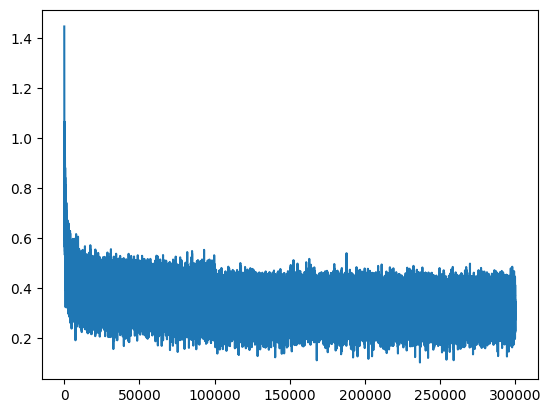

In [93]:
plt.plot(stepi, lossi)

In [94]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss


tensor(2.1146, grad_fn=<NllLossBackward0>)

In [95]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss


tensor(2.1569, grad_fn=<NllLossBackward0>)

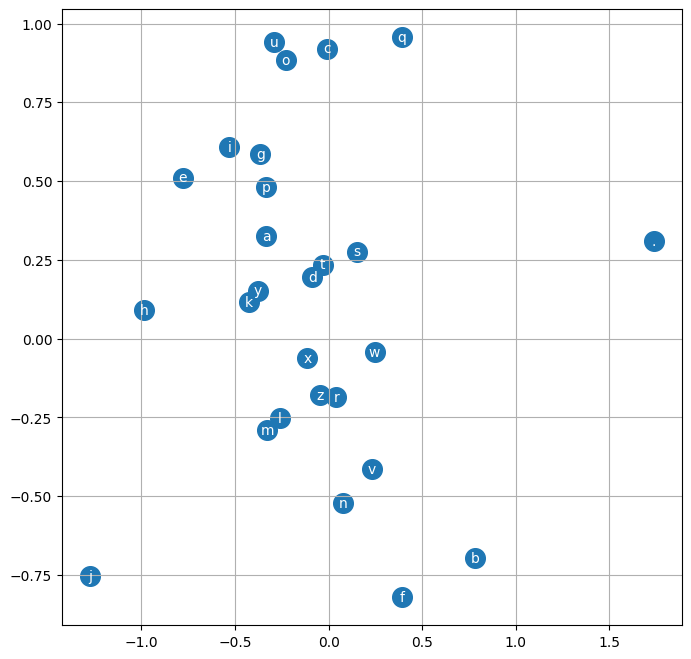

In [96]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [104]:
# sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

ceri.
kaemonurailah.
tyhamellistana.
nylandr.
kaida.
samiyah.
javar.
gotti.
moziellah.
jacoteda.
kaley.
maside.
enkavion.
ryslam.
huniden.
tahlasu.
jade.
breenley.
alaisa.
jana.
